In [1]:
import pandas as pd
import numpy as np
import joblib

from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV

from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import TfidfVectorizer

import pandas as pd
import numpy as np

import os
import joblib

from tqdm import tqdm

from plotnine import ggplot, aes, geoms

# get procedural stop words
%run procedural_stop_words.py

In [2]:
with open('Results/Official_TopicModel_80k.pkl','rb') as File:
    models = joblib.load(File)
    
all_df = pd.read_csv('Results/All_speeches_labelled.csv')

In [14]:
def make_binary_matrix(X):
    dummy_x = np.zeros(X.shape)
    for i,val in enumerate(np.argmax(X,1)):
        dummy_x[i,val] = 1
    return dummy_x

In [16]:
def select_data(year):
    """
    convenience function for extracting X,Y data and dataframe
    """
    sub_df = all_df.loc[all_df.year_x == year]
    model = [mod for mod in models['window_models'] if mod['year'] == year][0]
    
    Y = np.array([1 if i == 'D' else 0 for i in sub_df.party_y])
    X = make_binary_matrix(model['W'])
    
    return X,Y,sub_df[['party_y','speaker']].reset_index()

In [17]:
kfold = StratifiedKFold(n_splits=10,shuffle=True)

In [18]:
def run_model(X,Y,df,year,type='lasso',Cs=np.arange(0.1,1,0.1)):

    Results = []
    
    # for values of C
    for C in Cs:
        
        # fit and test model on all 10 cross validation folds
        if type == 'lasso':
            mod = LogisticRegression(penalty='l1',solver='liblinear',class_weight='balanced',C=C)
        elif type == 'svc':
            svc = LinearSVC(penalty='l1',class_weight='balanced',C=C,dual=False)
            mod = CalibratedClassifierCV(svc)
            
        predict_probs = np.zeros(len(Y)) # empty array for speach probabilities
        k_fold_vals = []
        
        for train_index, test_index in kfold.split(X, Y):
            X_train,X_test = X[train_index],X[test_index]
            Y_train,Y_test = Y[train_index],Y[test_index]
            
            # fit model predict test set
            mod.fit(X_train,Y_train)
            predictions = mod.predict(X_test)
            
            # get accuracy
            speech_accuracy = sum([1 for ix,i in enumerate(predictions) if i == Y_test[ix]])/len(Y_test)
            k_fold_vals.append(speech_accuracy)

            # get probability of being Democrat for every speech
            Dem_probs = [i[1] for i in mod.predict_proba(X_test)]
            predict_probs[test_index] = Dem_probs

        Results.append({"C":C,'mean_acc':np.mean(k_fold_vals),'std':np.std(k_fold_vals),'Dem_probs':predict_probs})

    C_frame = pd.DataFrame(Results)

    # select the best performing model
    best_row = C_frame.sort_values(by='mean_acc',ascending=False).reset_index().loc[0].to_dict()
    best_row['year'] = year
    
    # Speaker_accuracy
    df['prob_party'] = predict_probs
    partisan_assigned = df.groupby('speaker').prob_party.mean().reset_index()

    partisan_assigned['predicted_party'] = partisan_assigned.prob_party.apply(lambda x: 'D' if x > 0.5 else 'R')

    correct_speaker = sum(df.groupby('speaker').party_y.first().reset_index()
                     .merge(partisan_assigned,on='speaker',how='inner')
                     .apply(lambda x: 1 if x.party_y == x.predicted_party else 0,1))
    
    # speaker accuracy overall
    best_row['speaker_acc'] = correct_speaker/len(partisan_assigned)
    
    speaker_party_true = df.groupby('speaker').party_y.first().reset_index()
    speaker_party_true = speaker_party_true.loc[speaker_party_true.party_y != 'I']
    speaker_party_true = speaker_party_true.merge(partisan_assigned,on='speaker').groupby('party_y')

    # mean probability and std for Dem and Rep speakers
    best_row['Dem_speaker_mean'],best_row['Rep_speaaker_mean'] = speaker_party_true.prob_party.mean()
    best_row['Dem_speaker_std'],best_row['Rep_speaker_std'] = speaker_party_true.prob_party.std()
        
    # refit on all data to get coefficients
    coefs = LogisticRegression(penalty='l1',solver='liblinear',class_weight='balanced',C=best_row['C']).fit(X,Y).coef_
    best_row['coefs'] = coefs
    
    return best_row


In [19]:
Years = []
for year in tqdm(range(1983,2017)):
    X,Y,df = select_data(year)
    Years.append(run_model(X,Y,df,year))
LASSO_Results = pd.DataFrame(Years)
LASSO_Results = LASSO_Results.drop('Dem_probs',1)

100%|██████████| 34/34 [01:00<00:00,  1.79s/it]


<AxesSubplot:xlabel='year'>

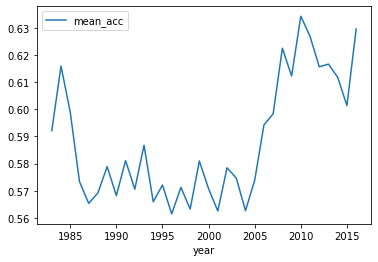

In [21]:
LASSO_Results.plot(x='year',y='mean_acc')

<AxesSubplot:xlabel='year'>

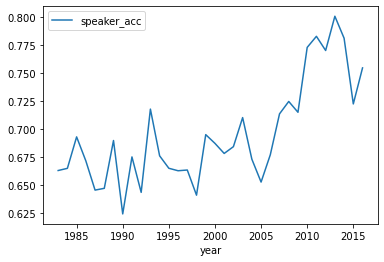

In [23]:
LASSO_Results.plot(x='year',y='speaker_acc')